In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# **Imports**

In [40]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
print(data.data.shape)
print(data.target_names)

X,y = data.data, data.target

(569, 30)
['malignant' 'benign']


# **Splitting**

In [41]:
# Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
N,D = X_train.shape # N = number of samples, D = number of features
print(N,D)

381 30


# **Scaling**

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # (x-mean)/std
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Model, loss and optimizer**

In [43]:
model = nn.Sequential(
    nn.Linear(D,1),
    nn.Sigmoid()
)
criterion = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(model.parameters())

## **Alternative :**
Use the logits loss to perform the sigmoid function (1/ (1 + exponential(a))) with the BCE loss (y log^y + (1-y)log(1-^y)) in a single function.

Avoids numerical instability

`model = nn.Linear(D,1)`

`criterion = nn.BCEWithLogitsLoss()`

`optimizer = torch.optim.Adam(model.parameters())`

In [45]:
# Data to tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).reshape(-1,1) # targets need to be reshaped to be a 2D array of size (N,1)
y_test = torch.from_numpy(y_test.astype(np.float32)).reshape(-1,1)

print([type(i) for i in [X_train, y_train, X_test, y_test]])

[<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


In [46]:
# Training

n_epochs = 1000
train_losses, test_losses = np.zeros(n_epochs), np.zeros(n_epochs)

for it in range(n_epochs):
  optimizer.zero_grad()

  # forward pass
  outputs = model(X_train)
  loss = criterion(outputs, y_train)
  train_losses[it] = loss.item()

  # backward pass and optimize 
  loss.backward()
  optimizer.step()

  # get test loss
  outputs_test = model(X_test)
  test_loss = criterion(outputs_test, y_test)
  test_losses[it] = test_loss.item()

  if (it+1) % 50 == 0:
    print(f'Epoch {it+1}/{n_epochs}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f} ')

Epoch 50/1000, train loss: 0.6901, test loss: 0.6901 
Epoch 100/1000, train loss: 0.4774, test loss: 0.5046 
Epoch 150/1000, train loss: 0.3660, test loss: 0.4034 
Epoch 200/1000, train loss: 0.3001, test loss: 0.3408 
Epoch 250/1000, train loss: 0.2567, test loss: 0.2981 
Epoch 300/1000, train loss: 0.2262, test loss: 0.2668 
Epoch 350/1000, train loss: 0.2035, test loss: 0.2428 
Epoch 400/1000, train loss: 0.1860, test loss: 0.2237 
Epoch 450/1000, train loss: 0.1721, test loss: 0.2083 
Epoch 500/1000, train loss: 0.1608, test loss: 0.1955 
Epoch 550/1000, train loss: 0.1514, test loss: 0.1846 
Epoch 600/1000, train loss: 0.1434, test loss: 0.1754 
Epoch 650/1000, train loss: 0.1366, test loss: 0.1674 
Epoch 700/1000, train loss: 0.1307, test loss: 0.1603 
Epoch 750/1000, train loss: 0.1255, test loss: 0.1541 
Epoch 800/1000, train loss: 0.1209, test loss: 0.1486 
Epoch 850/1000, train loss: 0.1168, test loss: 0.1437 
Epoch 900/1000, train loss: 0.1131, test loss: 0.1392 
Epoch 950/1

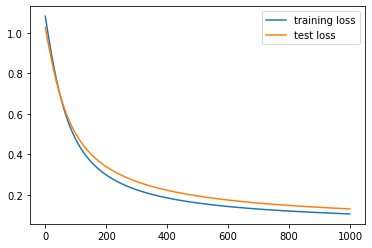

In [47]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import classification_report

preds = model(X_test).detach().numpy().round()
print(classification_report(preds, y_test.numpy()))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        63
         1.0       0.98      0.97      0.98       125

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.96       188
weighted avg       0.97      0.97      0.97       188



In [49]:
# Compute accuracy

with torch.no_grad():
  p_train = model(X_train)
  p_train = np.round(p_train.numpy())
  train_acc = np.mean(y_train.numpy() == p_train)

  p_test = model(X_test)
  p_test = np.round(p_test.numpy())
  test_acc = np.mean(y_test.numpy() == p_test)

  print(f'train accuracy: {train_acc:.4f}, test accuracy: {test_acc:.4f}')

train accuracy: 0.9869, test accuracy: 0.9681


# **Saving and loading models**

In [54]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1703, -0.4502, -0.3883, -0.3669, -0.2208, -0.3841, -0.3360, -0.3314,
                       -0.1607,  0.7066, -0.1965,  0.0925, -0.2788, -0.3890,  0.0250,  0.0447,
                       -0.1085, -0.2887,  0.2085,  0.5261, -0.2088, -0.3506, -0.3279, -0.2423,
                       -0.2778, -0.1758, -0.2787, -0.1758, -0.3062, -0.2829]])),
             ('0.bias', tensor([0.3749]))])

In [55]:
torch.save(model.state_dict(), 'models/classification_model.pt')

In [56]:
# load
loaded_model = nn.Sequential(
    nn.Linear(D,1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('models/classification_model.pt'))

<All keys matched successfully>